## Load Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

## Create Function to inspect DataFrame at high Level

In [2]:
def dataframe_overview(df):
    print("DataFrame info:")
    print("--------------------")
    print(df.info())
    print("\nDescribe DataFrame:")
    print("---------------------------------------------")
    print(df.describe())
    print("\nCount(Distinct):")
    print("-------------------------")
    print(df.nunique())
    print(f"\nNumber of observations: {df.shape[0]}")
    print("\nData Types:")
    print("-----------")
    print(df.dtypes)
    ##titanic_df_train.isna().sum()
    print("\nIsNASum:")
    print("-----------")
    print(df.isna().sum())


## Load the Kaggle Files from local (You can also do it direct from their website)

In [3]:
titanic_df_train = pd.read_csv('train.csv')
titanic_df_test = pd.read_csv('test.csv')

##Combine the files to make Feature Engineering Easier

concatenated_df = pd.concat([titanic_df_train, titanic_df_test], ignore_index=True)

In [4]:
dataframe_overview(concatenated_df)

DataFrame info:
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None

Describe DataFrame:
---------------------------------------------
       PassengerId    Survived       Pclass          Age        SibSp  \
count  1309.000000  891.000000  1309.000000  1046.000000  1

## Feature Engineering

#### Credit goes to Maciej Sabalski for providing the Feature Engineering Code and Analysis: 
#### https://www.kaggle.com/code/maciejsabalski/titanic-eda-feature-engeneering-and-ml/notebook

#### Handling Missing Data
#### Label Encoding
#### Transforming Continuous variables
#### Recoding Categorical Variables



In [5]:
concatenated_df['Name']

0                                 Braund, Mr. Owen Harris
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                  Heikkinen, Miss. Laina
3            Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                                Allen, Mr. William Henry
                              ...                        
1304                                   Spector, Mr. Woolf
1305                         Oliva y Ocana, Dona. Fermina
1306                         Saether, Mr. Simon Sivertsen
1307                                  Ware, Mr. Frederick
1308                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

In [6]:
# Extracting Title from Name
concatenated_df['Title'] = concatenated_df['Name'].apply(lambda x: x.split(', ')[1].split('.')[0])

In [7]:
title_counts = concatenated_df['Title'].value_counts()
print(title_counts)

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Ms                2
Major             2
Sir               1
the Countess      1
Jonkheer          1
Lady              1
Mme               1
Dona              1
Don               1
Capt              1
Name: Title, dtype: int64


In [8]:
concatenated_df['Title'] = concatenated_df['Title'].apply(lambda x: x if title_counts[x] > 10 else 'Misc')

In [9]:
ticket_count = concatenated_df['Ticket'].value_counts()
print(ticket_count)

CA. 2343              11
1601                   8
CA 2144                8
3101295                7
347082                 7
                      ..
SOTON/O.Q. 3101314     1
2667                   1
C.A. 34644             1
2621                   1
347471                 1
Name: Ticket, Length: 929, dtype: int64


In [10]:
concatenated_df['Alone_ticket'] = concatenated_df['Ticket'].apply(lambda x: 0 if ticket_count[str(x)]<=1 else 1)

In [11]:
concatenated_df['Ticket_Count'] = concatenated_df['Ticket'].apply(lambda x: ticket_count[str(x)])

In [12]:
concatenated_df['Ticket_Code'] = concatenated_df['Ticket'].apply(lambda x: str(x[:1]))


In [13]:
print(concatenated_df['Ticket_Code'].value_counts())

3    429
2    278
1    210
S     98
P     98
C     77
A     42
W     19
7     13
F     13
4     11
6      9
L      5
5      3
9      2
8      2
Name: Ticket_Code, dtype: int64


In [14]:
concatenated_df[~concatenated_df.Survived.isna()].groupby('Ticket_Code').agg({'Survived':['mean','count']})

Survived      
                 mean count
Ticket_Code                
1            0.630137   146
2            0.464481   183
3            0.239203   301
4            0.200000    10
5            0.000000     3
6            0.166667     6
7            0.111111     9
8            0.000000     2
9            1.000000     1
A            0.068966    29
C            0.340426    47
F            0.571429     7
L            0.250000     4
P            0.646154    65
S            0.323077    65
W            0.153846    13

In [15]:
T_asis = ['1', '2', '3', 'S', 'P', 'C', 'A']
T_ls = ['4','5','6','7','8','L','W' ]
# 1, 2, 3, S, P, C, A - Leave as is
# 4,5,6,7,8,L,W - Low Survival
# Rest - High Survival
def bin_ticket(tckt):
    if tckt in T_asis:
        return tckt
    elif tckt in T_ls:
        return 'LS'
    else:
        return 'HS'

In [16]:
concatenated_df['Ticket_Code_Short'] = concatenated_df['Ticket_Code'].apply(lambda x: bin_ticket(x))

In [17]:
concatenated_df['has_cabin'] = concatenated_df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

In [18]:
concatenated_df['Cabin'].fillna('Unknown',inplace=True)

In [19]:
concatenated_df['Cabin_Code'] = concatenated_df['Cabin'].apply(lambda x:str(x)[0])

In [20]:
def change_cabin_letter(pclass,cabin_code):
    if pclass == 1 and cabin_code == 'U':
        return 'C'
    elif pclass == 2 and cabin_code == 'U':
        return 'D'
    elif pclass == 3 and cabin_code == 'U':
        return 'G'
    elif cabin_code == 'T':
        return 'C'
    else:
        return cabin_code

In [21]:
concatenated_df['Cabin_Code'] = concatenated_df.apply(lambda x: change_cabin_letter(x.Pclass,x.Cabin_Code),axis=1)

In [22]:
print(concatenated_df['Cabin_Code'].value_counts())

G    698
D    300
C    162
B     65
E     41
A     22
F     21
Name: Cabin_Code, dtype: int64


In [23]:
# dropping unnecessary columns
if 'has_cabin' in concatenated_df.columns:
    concatenated_df = concatenated_df.drop(columns=['has_cabin'])
    
concatenated_df = concatenated_df.drop(columns = ['Cabin','Name'])

In [24]:
AgeByPclass = concatenated_df.groupby(['Pclass']).median('Age')['Age'].to_dict()
AgeByPclass

{1: 39.0, 2: 29.0, 3: 24.0}

In [25]:
concatenated_df['Age'] = concatenated_df.apply(lambda x: x.Age if not pd.isna(x.Age) else AgeByPclass[x.Pclass],axis = 1)

In [26]:
embarked_mode = concatenated_df['Embarked'].mode()[0]
embarked_mode

'S'

In [27]:
concatenated_df['Embarked'].fillna(embarked_mode,inplace = True)

In [28]:
FareByPclass = concatenated_df.groupby(['Pclass']).median('Fare')['Fare'].to_dict()
FareByPclass

{1: 60.0, 2: 15.0458, 3: 8.05}

In [29]:
concatenated_df['Fare'] = concatenated_df.apply(lambda x: x.Fare if not pd.isna(x.Fare) else FareByPclass[x.Pclass],axis = 1)

In [30]:
concatenated_df['FamilyOnBoard'] = concatenated_df['Parch'] + concatenated_df['SibSp']

In [31]:
concatenated_df['Sex'] = concatenated_df.Sex.apply(lambda x: 0 if x == "female" else 1)

In [32]:
concatenated_df.isna().sum()

PassengerId            0
Survived             418
Pclass                 0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Embarked               0
Title                  0
Alone_ticket           0
Ticket_Count           0
Ticket_Code            0
Ticket_Code_Short      0
Cabin_Code             0
FamilyOnBoard          0
dtype: int64

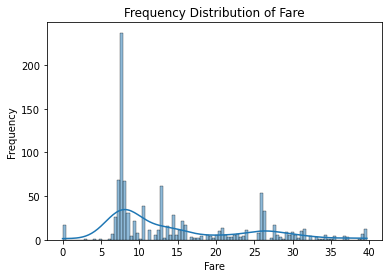

In [33]:
import seaborn as sns

##concatenated_df[concatenated_df['Fare'] < 100]


sns.histplot(concatenated_df['Fare'][concatenated_df['Fare'] < 40], bins=100, kde=True)  # KDE line adds a density plot
plt.xlabel('Fare')  # Replace with your column name
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Fare')  # Replace with your column title
plt.show()

In [34]:
def MakeFareCategory(value):
    if value < 7.9:
        return 'V'
    elif 7.9 <= value < 14.5:
        return 'C'
    elif value < 31.275:
        return 'B'
    else:
        return 'A'

In [35]:
concatenated_df['FareCategory'] = concatenated_df['Fare'].apply(MakeFareCategory)

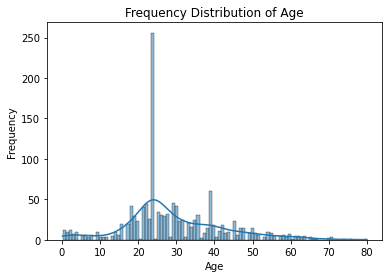

In [36]:
import seaborn as sns

##concatenated_df[concatenated_df['Fare'] < 100]


sns.histplot(concatenated_df['Age'][concatenated_df['Age'] < 100], bins=100, kde=True)  # KDE line adds a density plot
plt.xlabel('Age')  # Replace with your column name
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Age')  # Replace with your column title
plt.show()

In [37]:
def MakeAgeCategory(value):
    if value < 13:
        return 'C'
    elif 13 <= value < 20:
        return 'T'
    elif  20 <= value < 35:
        return 'YA'
    elif  35 <= value < 50:
        return 'A'
    else:
        return 'E'

In [38]:
concatenated_df['AgeCategory'] = concatenated_df['Age'].apply(MakeAgeCategory)

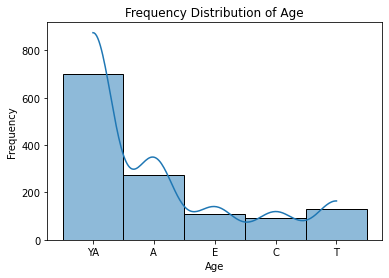

In [39]:
import seaborn as sns

##concatenated_df[concatenated_df['Fare'] < 100]


sns.histplot(concatenated_df['AgeCategory'][concatenated_df['Age'] < 100], bins=100, kde=True)  # KDE line adds a density plot
plt.xlabel('Age')  # Replace with your column name
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Age')  # Replace with your column title
plt.show()

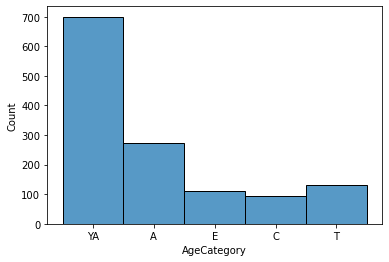

In [40]:


# Plotting
sns.histplot(concatenated_df['AgeCategory'])
plt.show()

In [41]:
concatenated_df[~concatenated_df.Survived.isna()].groupby('AgeCategory').agg({'Survived':['mean','count']})

Survived      
                 mean count
AgeCategory                
A            0.424084   191
C            0.579710    69
E            0.364865    74
T            0.410526    95
YA           0.335498   462

In [42]:
concatenated_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Alone_ticket,Ticket_Count,Ticket_Code,Ticket_Code_Short,Cabin_Code,FamilyOnBoard,FareCategory,AgeCategory
0,1,0.0,3,1,22.0,1,0,A/5 21171,7.2500,S,Mr,0,1,A,A,G,1,V,YA
1,2,1.0,1,0,38.0,1,0,PC 17599,71.2833,C,Mrs,1,2,P,P,C,1,A,A
2,3,1.0,3,0,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1,S,S,G,0,C,YA
3,4,1.0,1,0,35.0,1,0,113803,53.1000,S,Mrs,1,2,1,1,C,1,A,A
4,5,0.0,3,1,35.0,0,0,373450,8.0500,S,Mr,0,1,3,3,G,0,C,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,1,24.0,0,0,A.5. 3236,8.0500,S,Mr,0,1,A,A,G,0,C,YA
1305,1306,NaN,1,0,39.0,0,0,PC 17758,108.9000,C,Misc,1,3,P,P,C,0,A,A
1306,1307,NaN,3,1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,Mr,0,1,S,S,G,0,V,A
1307,1308,NaN,3,1,24.0,0,0,359309,8.0500,S,Mr,0,1,3,3,G,0,C,YA


## Split Tidy data into Dependent, Indepent Variables, Train and Test

In [43]:
ds_df = concatenated_df.drop(['PassengerId',
                              'SibSp', 'Parch', 'Ticket',  'Ticket_Code'], axis=1).copy() # alternatively: X = df_no_missing.iloc[:,:-1]


ds_df = pd.get_dummies(ds_df, columns=['Embarked', 'Title', 'Ticket_Code_Short', 'Cabin_Code', 'AgeCategory', 'FareCategory'])

X_train = ds_df[~ds_df['Survived'].isna()]
X_test = ds_df[ds_df['Survived'].isna()]
y_train = ds_df['Survived'][~ds_df['Survived'].isna()]
X_train= X_train.drop(['Survived'], axis =1).copy()
X_test= X_test.drop(['Survived'], axis =1).copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



## XGBoost with Grid Search for Hyperparameter tuning on the Training set

In [44]:
import xgboost as xgb # XGBoost stuff

## NOTE: This code takes a few minutes to run, so I've commented it out.
## Since I set seed=42, we'll get the same results anyway, and those are
## coded into the next section...

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'n_estimators': range(50, 250, 50),
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0, 1.0, 10.0, 100.0],
    'random_state': [0]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric="logloss", seed=23, use_label_encoder=False),
    param_grid=param_grid,
    scoring = 'accuracy',
    verbose=2,
    n_jobs = 10,
    cv = 5
)

optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'random_state': 0, 'reg_lambda': 10.0}


In [45]:
from sklearn.metrics import accuracy_score

# Get the best model
best_model = optimal_params.best_estimator_

# Predict on the training data
train_predictions = best_model.predict(X_train)

# Calculate training accuracy
training_accuracy = accuracy_score(y_train, train_predictions)

# Print training accuracy
print("Training Accuracy:", training_accuracy)

Training Accuracy: 0.9023569023569024


In [46]:
#read sample submit file
sample_submit_file = pd.read_csv('gender_submission.csv')

# Predict on the training data
test_predictions = best_model.predict(X_test)

optim_xg_submitfile = sample_submit_file

In [47]:
optim_xg_submitfile = pd.concat([sample_submit_file['PassengerId'], pd.Series(test_predictions)], axis=1)
optim_xg_submitfile.rename(columns={optim_xg_submitfile.columns[1]: 'Survived'}, inplace=True)

In [48]:
optim_xg_submitfile.to_csv('optimizedxgboost.csv', index=False)

## Hyperparamater  Tuning ADABoost

In [49]:
from sklearn.ensemble import AdaBoostClassifier


clf_adaboost = AdaBoostClassifier(random_state=42)

# Define hyperparameter grid for AdaBoost
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0]
}

# GridSearchCV setup
grid_search = GridSearchCV(clf_adaboost, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Getting the best AdaBoost model from the grid search
clf_adaboost_optimized = grid_search.best_estimator_

# Print the best hyperparameters found by GridSearchCV
print("Best Hyperparameters for AdaBoost Classifier:")
print(grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Optionally, print the detailed classification report
best_ada = grid_search.best_estimator_
test_predictions = best_ada.predict(X_test)



test_predictions_str = test_predictions.astype(int).astype(str)

optim_ada_submitfile = pd.concat([sample_submit_file['PassengerId'], pd.Series(test_predictions_str)], axis=1)
optim_ada_submitfile.rename(columns={optim_ada_submitfile.columns[1]: 'Survived'}, inplace=True)


optim_ada_submitfile.to_csv('optim_ada.csv', index=False)




Best Hyperparameters for AdaBoost Classifier:
{'learning_rate': 1.0, 'n_estimators': 10}
Best score:  0.8305065595380077


## Hyperparamater Tuning Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report


# Define the parameter grid, including the 'criterion' parameter



# Define the parameter grid, including the 'criterion' parameter
param_grid = {
    'criterion': ['gini', 'entropy'],  # Criterion for split quality
    'n_estimators': [10,25,50,100, 150, 200, 250, 300],   # Number of trees in the forest
    'max_depth': [None, 5,6,7,8,9,10, 13,15, 20,25, 30],   # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required at a leaf node
    'bootstrap': [True, False]         # Whether bootstrap samples are used when building trees
}

# Initialize the classifier
rf = RandomForestClassifier()

# Initialize GridSearchCV with the classifier, parameter grid, and number of folds for cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Optionally, print the detailed classification report
best_rf = grid_search.best_estimator_
print("best Estimator: ", best_rf)





Fitting 3 folds for each of 3456 candidates, totalling 10368 fits
Best parameters found:  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best score:  0.8484848484848485
best Estimator:  RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_leaf=2,
                       n_estimators=50)


In [51]:
test_predictions = best_rf.predict(X_test)

test_predictions_str = test_predictions.astype(int).astype(str)

optim_rf_submitfile = pd.concat([sample_submit_file['PassengerId'], pd.Series(test_predictions_str)], axis=1)
optim_rf_submitfile.rename(columns={optim_rf_submitfile.columns[1]: 'Survived'}, inplace=True)


optim_rf_submitfile.to_csv('optimized_rf.csv', index=False)

##  Testing Best Random Forest on Training Data

In [52]:
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import classification_report



# Define the parameter grid, including the 'criterion' parameter
params = {
    'n_estimators': [250],
    'criterion': ['gini'],
    'max_depth': [9],
    'random_state': [0],
}

# Initialize the classifier
rf = RandomForestClassifier()

# Initialize GridSearchCV with the classifier, parameter grid, and number of folds for cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=params, cv=5, n_jobs=4, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Optionally, print the detailed classification report
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)





Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 250, 'random_state': 0}
Best score:  0.8473793233318687


In [53]:
test_predictions = best_rf.predict(X_test)

test_predictions_str = test_predictions.astype(int).astype(str)

generalized_rf_submitfile = pd.concat([sample_submit_file['PassengerId'], pd.Series(test_predictions_str)], axis=1)
generalized_rf_submitfile.rename(columns={generalized_rf_submitfile.columns[1]: 'Survived'}, inplace=True)


generalized_rf_submitfile.to_csv('bestexp_rf.csv', index=False)

## Hyperparamater Tuning Support Vector Machine

In [54]:

from sklearn.svm import SVC
# Initialize SVM
svm = SVC()

# Define hyperparameter options
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly']
}

# Create GridSearchCV object
grid_search = GridSearchCV(svm, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Evaluate the model
# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("Best estim: ", grid_search.best_estimator_)

best_svm = grid_search.best_estimator_
test_predictions = best_svm.predict(X_test)


test_predictions_str = test_predictions.astype(int).astype(str)

best_svm_submitfile = pd.concat([sample_submit_file['PassengerId'], pd.Series(test_predictions_str)], axis=1)
best_svm_submitfile.rename(columns={best_svm_submitfile.columns[1]: 'Survived'}, inplace=True)


best_svm_submitfile.to_csv('optim_svm.csv', index=False)

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best score: 0.8417362375243238
Best parameters found:  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best score:  0.8417362375243238
Best estim:  SVC(C=1, kernel='linear')


## Voting Classifier with Random Forest and XGBoost and ADABoost

In [55]:

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier



rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
##'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 1.0
gb_clf = GradientBoostingClassifier(learning_rate = .05, max_depth = 5,  n_estimators=100, random_state=42)
ab_clf = AdaBoostClassifier(n_estimators=10, learning_rate = 1, random_state=42)

# Train the individual classifiers
rf_clf.fit(X_train, y_train)
gb_clf.fit(X_train, y_train)
ab_clf.fit(X_train, y_train)




voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf), ('ab', ab_clf)],
    voting='soft'
)

# Train the VotingClassifier
voting_clf.fit(X_train, y_train)


# Make predictions
rf_pred = rf_clf.predict(X_test)
gb_pred = gb_clf.predict(X_test)
ab_pred = ab_clf.predict(X_test)
##y_pred = voting_clf.predict(X_test)


test_predictions = voting_clf.predict(X_test)

test_predictions_str = test_predictions.astype(int).astype(str)

generalized_rf_submitfile = pd.concat([sample_submit_file['PassengerId'], pd.Series(test_predictions_str)], axis=1)
generalized_rf_submitfile.rename(columns={generalized_rf_submitfile.columns[1]: 'Survived'}, inplace=True)


generalized_rf_submitfile.to_csv('bigvoting_soft.csv', index=False)

## Voting Classifier with SVM and Random Forest

In [56]:


# RandomForestClassifier instantiation
rf_model = RandomForestClassifier(
    n_estimators=250, criterion='gini', max_depth=9, 
    min_samples_split=10, min_samples_leaf=1, bootstrap=True
)

# XGBClassifier instantiation
xgb_model = xgb.XGBClassifier(
    max_depth=7, learning_rate=0.01, n_estimators=100,
    objective='binary:logistic', booster='gbtree', tree_method='auto', 
    n_jobs=1, gpu_id=-1, gamma=0, min_child_weight=1, max_delta_step=0, 
    subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, 
    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, 
    random_state=0, missing=None, num_parallel_tree=1, 
    monotone_constraints='()', interaction_constraints='', 
    importance_type='gain', validate_parameters=1, predictor='auto'
)

# AdaBoostClassifier instantiation
ada_model = AdaBoostClassifier(n_estimators=10, learning_rate=1, random_state=42)

# SVC instantiation
svm_model = SVC(probability=True, random_state=42, C = 1, gamma = 'scale', kernel = 'linear')  # Enable probability estimation

##'C': 1, 'gamma': 'scale', 'kernel': 'linear'


# Create voting classifier with added SVM
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),
       ## ('xgb', xgb_model),
       ## ('ada', ada_model),
        ('svm', svm_model)  # Add SVM model here
    ],
    voting='hard'  # Use 'soft' for probability-based voting
)

voting_clf.fit(X_train, y_train)

test_predictions = voting_clf.predict(X_test)

test_predictions_str = test_predictions.astype(int).astype(str)

generalized_rf_submitfile = pd.concat([sample_submit_file['PassengerId'], pd.Series(test_predictions_str)], axis=1)
generalized_rf_submitfile.rename(columns={generalized_rf_submitfile.columns[1]: 'Survived'}, inplace=True)


generalized_rf_submitfile.to_csv('svmvoting_hard.csv', index=False)